In [25]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from transformers import AutoTokenizer, AutoModelForSequenceClassification, pipeline
import torch
from tqdm import tqdm


In [9]:
# Carica il modello
model_name = "unitary/toxic-bert"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForSequenceClassification.from_pretrained(model_name)

In [10]:
# Carica i messaggi
df = pd.read_csv("../../data/processed/cleaned_twitch_messages.csv")

In [11]:
# Funzione per stimare la tossicità
def get_toxicity_score(text):
    inputs = tokenizer(text, return_tensors="pt", truncation=True, padding=True)
    with torch.no_grad():
        outputs = model(**inputs)
    # Usa il punteggio massimo tra le 6 classi
    score = torch.sigmoid(outputs.logits)[0].max().item()
    return score

In [12]:
# Applica ai messaggi
tqdm.pandas()
df["toxicity_score"] = df["message"].progress_apply(get_toxicity_score)

100%|██████████| 57805/57805 [20:24<00:00, 47.22it/s]


In [13]:
# Etichette: 1 = tossico, 0 = non tossico, -1 = ambiguo
df["label"] = df["toxicity_score"].apply(lambda x: 1 if x >= 0.7 else (0 if x <= 0.3 else -1))

In [14]:
# Salva
df.to_csv("messages_with_toxicity_labels.csv", index=False)
print("✅ Etichettatura completata.")


✅ Etichettatura completata.


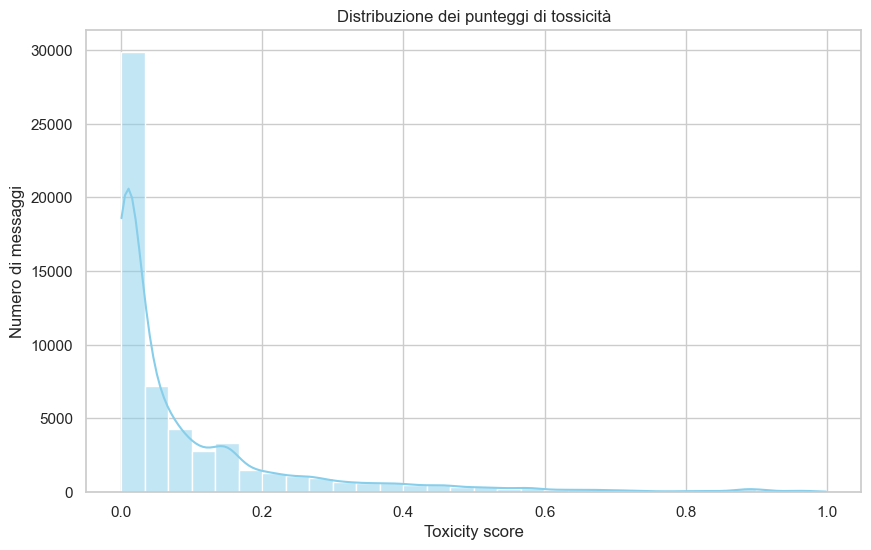

In [15]:
# 6️⃣ Visualizzazione del punteggio
sns.set(style="whitegrid")
plt.figure(figsize=(10, 6))
sns.histplot(data=df, x="toxicity_score", bins=30, kde=True, color="skyblue")
plt.title("Distribuzione dei punteggi di tossicità")
plt.xlabel("Toxicity score")
plt.ylabel("Numero di messaggi")
plt.show()

### Prova con CitizenLab distilbert-base-multilingual-cased-toxicity

In [23]:
# Modello multilingua specializzato in tossicità
MODEL_NAME = "citizenlab/distilbert-base-multilingual-cased-toxicity"

In [26]:
toxicity_classifier = pipeline("text-classification", model=MODEL_NAME, tokenizer=MODEL_NAME)

Device set to use cpu


In [27]:
# Funzione per etichettare e ottenere score
def classify_toxicity(text):
    result = toxicity_classifier(text[:512])[0]  # truncation manuale max input
    label = 1 if result["label"] == "toxic" else 0
    score = result["score"]
    return pd.Series([label, score])

In [28]:
# Applica con progress bar
tqdm.pandas()
df[["label", "toxicity_score"]] = df["message"].progress_apply(classify_toxicity)

100%|██████████| 57805/57805 [09:44<00:00, 98.83it/s] 


In [37]:
# Etichette: soglie personalizzabili
df["label"] = df["toxicity_score"].apply(lambda x: 1 if x >= 0.6 else 0)

In [38]:
df.to_csv("messages_labeled_citizenlab.csv", index=False)
print("✅ Etichettatura completata con il modello CitizenLab.")

✅ Etichettatura completata con il modello CitizenLab.


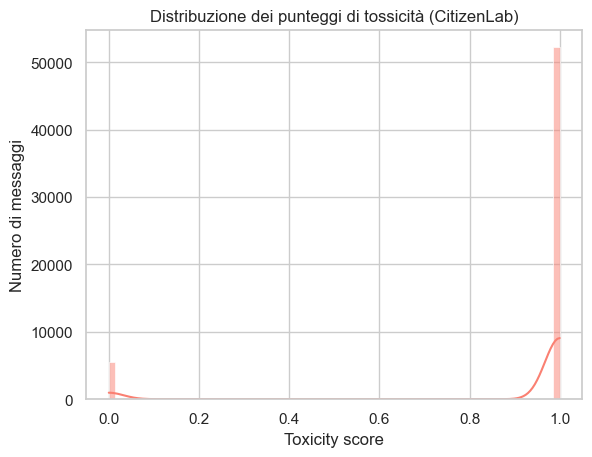

In [41]:
sns.histplot(df["label"], bins=70, kde=True, color="salmon")
plt.title("Distribuzione dei punteggi di tossicità (CitizenLab)")
plt.xlabel("Toxicity score")
plt.ylabel("Numero di messaggi")
plt.show()